# Exploratory Data Analysis (EDA)

**🔄 EDA Workflow for Classification**

- 🔍 Data Snapshot: Use `df.head()`, `.info()`, and `.describe()` to check the basic structure, data types, and missing values.  
- 🎯 Target Check: Run `y.value_counts()` to verify class labels and spot imbalance.
- 🧩 Variable Typing: Confirm feature types—numerical, categorical, text, or date. Use the type-detection script from Milestone 3 Lesson 1.
- 📊 Univariate Exploration:  
  - Numeric: Histograms or KDE plots  
  - Categorical: Countplots
- 🧪 Bivariate Exploration:  
  - Box/violin plots for numeric features across classes  
  - Stacked bar plots for categorical features vs. target
- 🔥 Correlation Heatmap: Use Spearman (for ranking) or Pearson (for linear) correlations to detect redundant numeric features.
- 🔀 Multivariate Preview: Use pair-plots or dimensionality reduction (e.g., t-SNE, PCA) to explore high-dimensional patterns.
- ⚖️ Class Balance Visualization: Plot class proportions side-by-side to detect severe imbalance.
- ❗ Missing & Outlier Maps:  
  - Heatmaps for missing values  
  - Scatterplots with Isolation Forest to highlight outliers

_NOTE_: This is an EDA approach where no data is changed. No imputation, outlier removal, or encoding—most of these actions cannot be applied to the whole dataset, as this would create leakage. See `05_data_split.ipynb` for data preprocessing steps.

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif

df = pd.read_csv("../data/interim/cleaned_yield_tables.csv")

target_variable = "tree_type"
features = [
    "age",
    "average_height",
    "dbh",
    "trees_per_ha",
    "basal_area",
]

df.head()

,tree_type,age,average_height,dbh,trees_per_ha,basal_area
0,coniferous,20.0,5.3,11.5,2585.0,26.8
1,coniferous,30.0,10.6,16.7,1708.0,37.5
2,coniferous,40.0,15.7,21.6,1266.0,46.3
3,coniferous,50.0,20.5,26.1,1003.0,53.5
4,coniferous,60.0,24.6,30.2,830.0,59.4


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8229 entries, 0 to 8228
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tree_type       8229 non-null   object 
 1   age             8229 non-null   float64
 2   average_height  8229 non-null   float64
 3   dbh             8229 non-null   float64
 4   trees_per_ha    8229 non-null   float64
 5   basal_area      8229 non-null   float64
dtypes: float64(5), object(1)
memory usage: 385.9+ KB


In [55]:
df[target_variable].value_counts()

tree_type
coniferous    4498
deciduous     3731
Name: count, dtype: int64

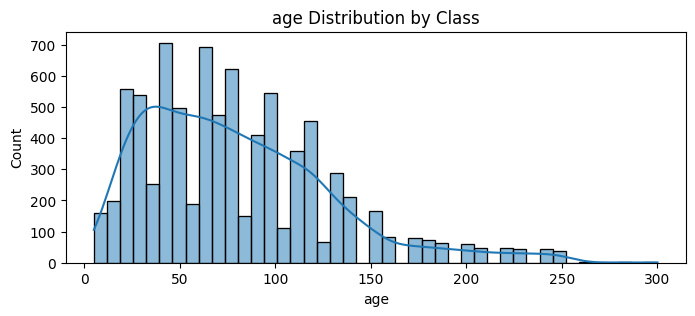

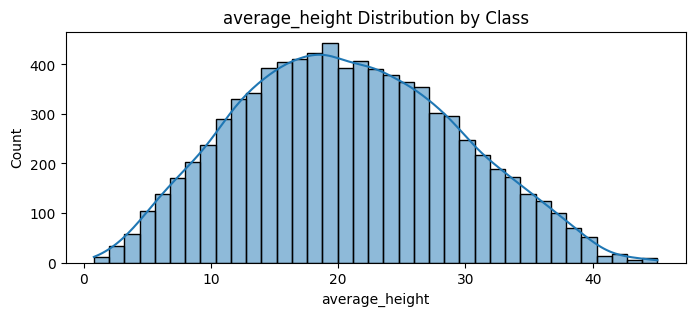

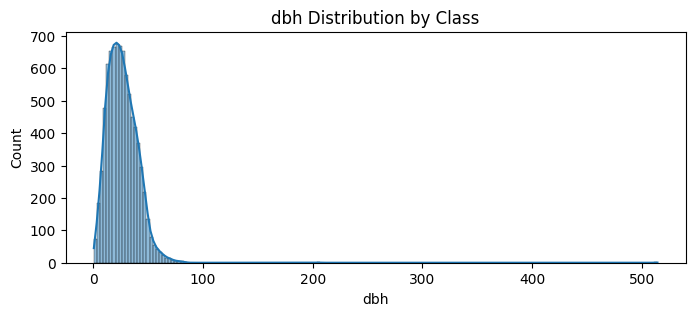

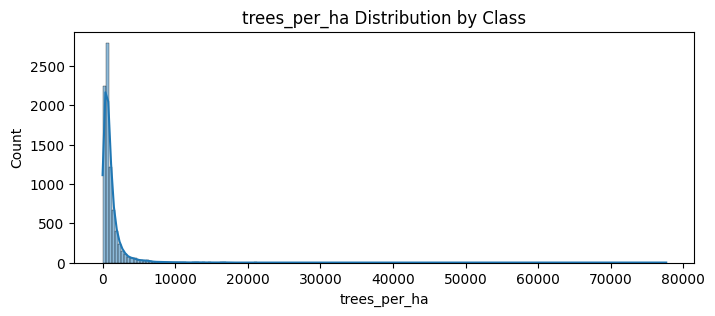

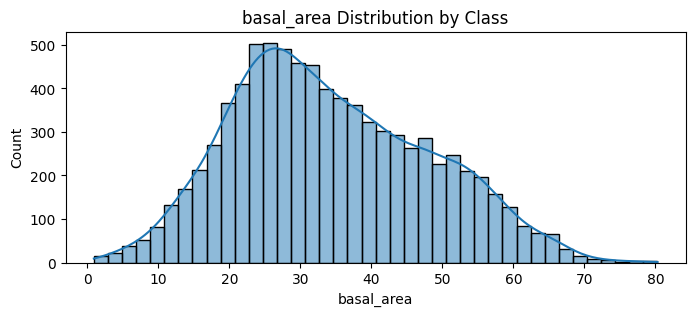

In [56]:
for feature in features:
    plt.figure(figsize=(8, 3))
    sns.histplot(df[feature], kde=True, multiple="stack")
    plt.title(f"{feature} Distribution by Class")
    plt.show()

## Chi-Squared

- The Chi-Square statistic looks at the relationship between two categorical variables.
- In classification, it’s often used between an input feature (categorical) and the target class.
- It asks: “Is the distribution of the feature values independent of the class label, or are they associated?”

**Interpretation:**

- A high Chi-Square value = strong association between feature and target → the feature is informative.
- A low Chi-Square value = weak association → the feature might not add much predictive power.

Since we don't have a categorical feature in our dataset this doesn't make a lot of sense here. We are still generating the scores for demonstration purposes.

In [57]:
for feature in features:
    ct = pd.crosstab(df[feature], df[target_variable])
    chi2, p, *_ = chi2_contingency(ct)
    print(
        f"Chi-square of {feature} with {target_variable}: {chi2:.2f}, p-value: {p:.3g}"
    )

Chi-square of age with tree_type: 1646.08, p-value: 3.25e-308
Chi-square of average_height with tree_type: 1556.71, p-value: 1.86e-05
Chi-square of dbh with tree_type: 1818.91, p-value: 0.00655
Chi-square of trees_per_ha with tree_type: 2616.61, p-value: 0.217
Chi-square of basal_area with tree_type: 4374.75, p-value: 3.38e-122


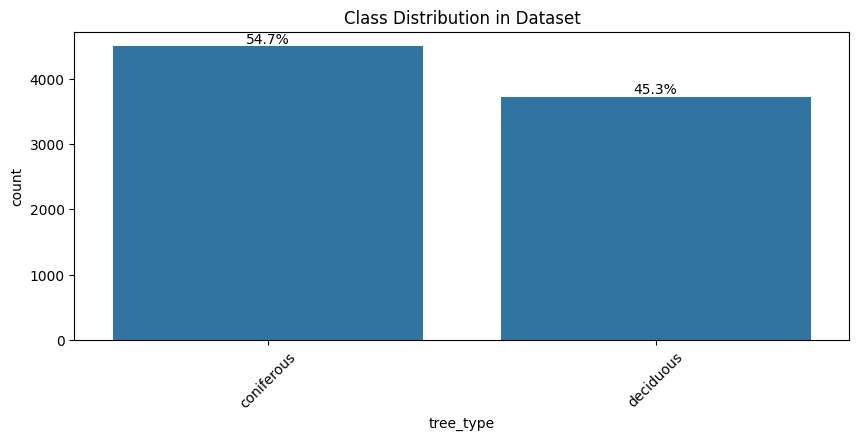

In [58]:
# Basic class distribution
plt.figure(figsize=(10, 4))
sns.countplot(
    data=df, x=target_variable, order=df[target_variable].value_counts().index
)
plt.title("Class Distribution in Dataset")
plt.xticks(rotation=45)

# Add percentage labels
total = len(df)
for p in plt.gca().patches:
    percentage = f"{100*p.get_height()/total:.1f}%"
    plt.gca().annotate(
        percentage,
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="bottom",
    )

The classes are well balanced (54,7% vs. 45,3%). No need for balancing techniques.

## MI Scores

Mutual Information (MI) scores measure the dependency between each feature and the target variable. Higher MI scores indicate that a feature provides more information about the target, making it potentially more useful for classification tasks. In this case, we will calculate the MI scores for all features in the dataset and visualize them using a bar plot. A lower MI score suggests that the feature may be less relevant for predicting the target variable.

In [59]:
mi_scores = mutual_info_classif(df[features], df[target_variable])

for feature, score in zip(features, mi_scores):
    print(f"MI score of {feature} with {target_variable}: {score:.4f}")

MI score of age with tree_type: 0.1210
MI score of average_height with tree_type: 0.0460
MI score of dbh with tree_type: 0.0345
MI score of trees_per_ha with tree_type: 0.0071
MI score of basal_area with tree_type: 0.2230


The MI scores show that the most informative features for predicting the target variable are `basal_area` and `age`, while `trees_per_ha` and `dbh` provide less relevant information. This insight can guide feature selection and engineering efforts in the modeling process.

## The Feature Engineering Pipeline

A professional workflow typically follows these steps:

- **Handle missing values** with domain-informed strategies.
- **Transform distributions** to align with algorithm assumptions.
- **Encode categorical variables** appropriately for their type and size.
- **Create interaction terms** between predictive feature pairs.
- **Generate domain-specific features** using business knowledge.
- **Scale numerical features** consistently across splits.
- **Select features** using statistical and model-based methods.

In [60]:
# Simple feature engineering plan
def plan_feature_engineering(df, target_col):
    """Simple planning function for feature engineering"""
    plan = {
        "numerical_features": [],
        "categorical_features": [],
        "datetime_features": [],
        "missing_features": [],
    }

    for col in df.columns:
        if col == target_col:
            continue

        if df[col].dtype in ["int64", "float64"]:
            plan["numerical_features"].append(col)
        elif df[col].dtype == "object":
            plan["categorical_features"].append(col)
        elif "datetime" in str(df[col].dtype):
            plan["datetime_features"].append(col)

        # Check for missing values
        if df[col].isnull().sum() > 0:
            plan["missing_features"].append(col)

    return plan


# Usage
plan = plan_feature_engineering(df, target_variable)
print("Feature engineering plan:")
for category, features in plan.items():
    print(f"{category}: {features}")

Feature engineering plan:
numerical_features: ['age', 'average_height', 'dbh', 'trees_per_ha', 'basal_area']
categorical_features: []
datetime_features: []
missing_features: []


## Show correlation heatmap

The correlation heatmap shows the relationships between numerical features in the dataset. High correlation between features may indicate redundancy, which can be addressed through feature selection or dimensionality reduction techniques. In this case, we will visualize the correlation matrix using a heatmap. 

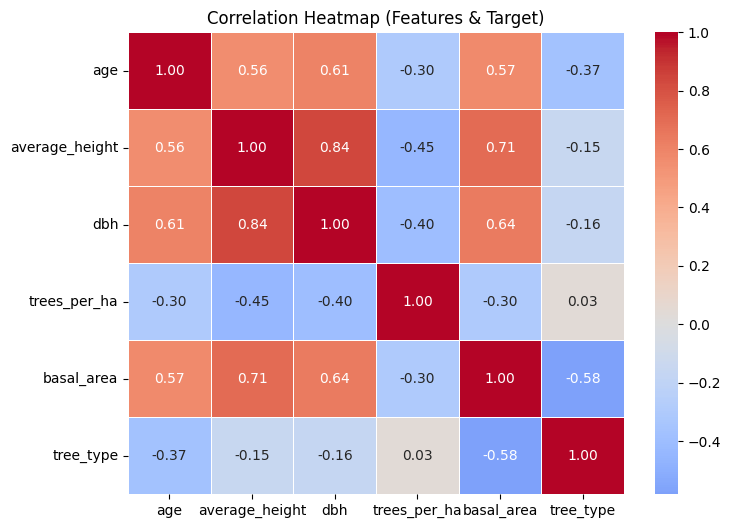

In [61]:
# Encode the target variable for correlation calculation
df_encoded = df.copy()
df_encoded[target_variable] = df_encoded[target_variable].astype("category").cat.codes

# Compute correlation matrix (including target)
corr = df_encoded[plan["numerical_features"] + [target_variable]].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".2f",
    linewidths=0.5,
)
plt.title("Correlation Heatmap (Features & Target)")
plt.show()

The heatmap shows that we have only one highly correlated feature pair (above 0.8), which is the `dbh` and `average_height`. This is expected, as trees with a larger diameter at breast height (dbh) tend to be taller on average. We could consider dropping one of these features to reduce redundancy. The rest of the feature paris show low to moderate correlation, indicating that they provide unique information for the classification task.